# 단변량 시계열 예측과 외생 변수

이 노트북에서는 외생 변수를 사용한 모델링을 다룰 것입니다. 우리의 작업 계획은 다음과 같습니다:

1. 시계열을 생성하는 과정에 대한 실질적인 통찰력을 얻기 위해 데이터셋에 대한 EDA를 수행합니다. **(이 노트북에서 다룸)**
2. 벤치마킹을 위한 기본 모델 (외생 변수 없는 단변량 모델)을 구축합니다.
3. 가능한 최고의 성능을 확인하기 위해 모든 외생 변수를 가진 단변량 모델을 구축합니다.
4. 외생 변수가 있는 모델을 평가하고 잠재적인 문제점을 논의합니다.
5. 위에서 확인된 문제점을 해결합니다.
6. 최적의 모델로 미래 예측을 수행합니다.
7. 자동 시계열 모델링 (AutoML)로 작업 흐름을 복제합니다.

In [1]:
# 오직 중요한 로깅만 활성화하기 (선택적)
import os
os.environ["PYCARET_CUSTOM_LOGGING_LEVEL"] = "CRITICAL"

In [2]:
def what_is_installed():
    from pycaret import show_versions
    show_versions()

try:
    what_is_installed()
except ModuleNotFoundError:
    !pip install pycaret
    what_is_installed()

  Using cached pycaret-3.0.4-py3-none-any.whl (484 kB)
  Using cached category_encoders-2.6.1-py2.py3-none-any.whl (81 kB)
  Using cached sktime-0.20.0-py3-none-any.whl (17.0 MB)
  Using cached kaleido-0.2.1-py2.py3-none-macosx_11_0_arm64.whl (85.8 MB)
  Using cached schemdraw-0.15-py3-none-any.whl (106 kB)
  Using cached scikit_plot-0.3.7-py3-none-any.whl (33 kB)
  Using cached plotly_resampler-0.9.1-py3-none-any.whl (73 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 53.7 MB/s eta 0:00:0000:01
  Using cached deprecation-2.1.0-py2.py3-none-any.whl (11 kB)
  Using cached tbats-1.1.3-py3-none-any.whl (44 kB)
  Using cached cloudpickle-2.2.1-py3-none-any.whl (25 kB)
  Using cached pmdarima-2.0.3-cp38-cp38-macosx_11_0_arm64.whl (573 kB)
  Using cached yellowbrick-1.5-py3-none-any.whl (282 kB)
  Using cached pyod-1.1.0.tar.gz (153 kB)
  Preparing metadata (setup.py) ... done
  Using cached wurlitzer-3.0.3-py3-none-any.whl (7.3 kB)
  Using cached xxhash-3.2.0-cp38-cp38-macosx_1

In [3]:
import numpy as np
import pandas as pd
from pycaret.datasets import get_data
from pycaret.time_series import TSForecastingExperiment

In [4]:
# 노트북을 위한 전역 그림 설정 ----
# 당신이 주피터 노트북, 주피터 랩, 구글 코랩을 사용하느냐에 따라, 그에 맞는 렌더러를 설정해야 할 수도 있습니다.
# 주의: 저장된 노트북의 크기를 줄이기 위해 여기서 정적 렌더러를 설정합니다.
global_fig_settings = {
# "renderer": "notebook",
    "renderer": "png",
    "width": 1000,
    "height": 600,
}

In [5]:
data = get_data("airquality")
data["index"] = pd.to_datetime(data["Date"] + " " + data["Time"])
data.drop(columns=["Date", "Time"], inplace=True)
target = "CO(GT)"

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,2004-03-10,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,2004-03-10,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,2004-03-10,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,2004-03-10,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


**이 데이터셋에는 -200으로 태그된 결측값이 있습니다. [참고](https://archive.ics.uci.edu/ml/datasets/air+quality). 이 값들을 제거해야합니다(그것들을 NaN으로 대체하십시오) 및 `pycaret`이 적절하게 대치를 처리하게 하십시오(훈련 중 데이터 유출 방지).**

In [6]:
data[data[target] == -200].head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,index
10,-200.0,1011,14,1.3,527,21,1818,34,1197,445,10.1,60.5,0.7465,2004-03-11 04:00:00
34,-200.0,831,10,1.1,506,21,1893,32,1134,384,6.1,65.9,0.6248,2004-03-12 04:00:00
39,-200.0,1545,-200,22.1,1353,-200,767,-200,2058,1588,9.2,56.2,0.6561,2004-03-12 09:00:00
58,-200.0,1147,56,6.2,821,109,1132,83,1412,992,7.0,71.1,0.7158,2004-03-13 04:00:00
82,-200.0,1130,56,5.2,773,70,1130,82,1452,1051,12.1,61.1,0.8603,2004-03-14 04:00:00


In [7]:
data.replace(-200, np.nan, inplace=True)
data[data[target] == -200]

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,index


이제, 우리의 EDA와 모델링으로 넘어가 봅시다.

# 탐색적 분석

In [8]:
# EDA 실험 만들기
eda = TSForecastingExperiment()

In [9]:
eda.setup(
    data=data,
    target=target,
    index="index",
    fh=48,
    numeric_imputation_target="ffill",
    numeric_imputation_exogenous="ffill",
# 플롯에 대한 기본 설정을 지정합니다 ----
    fig_kwargs=global_fig_settings,
    session_id=42,
)

,Description,Value
0,session_id,42
1,Target,CO(GT)
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(9357, 13)"
5,Transformed data shape,"(9357, 13)"
6,Transformed train set shape,"(9309, 13)"
7,Transformed test set shape,"(48, 13)"
8,Rows with missing values,91.2%
9,Fold Generator,ExpandingWindowSplitter


진행하기에 앞서, 여기에서 몇 가지 유용한 정보를 관찰할 수 있습니다.

1. 데이터는 시간당 데이터셋이므로, 24시간 주기가 테스트되었습니다. 이 시간 주기에서 계절성이 감지되었습니다.
2. 데이터의 성격 때문에 모델링하면서 데이터를 차분하는 것이 권장됩니다(d=1). 우리는 이를 EDA 과정에서 더 평가해 볼 것입니다.

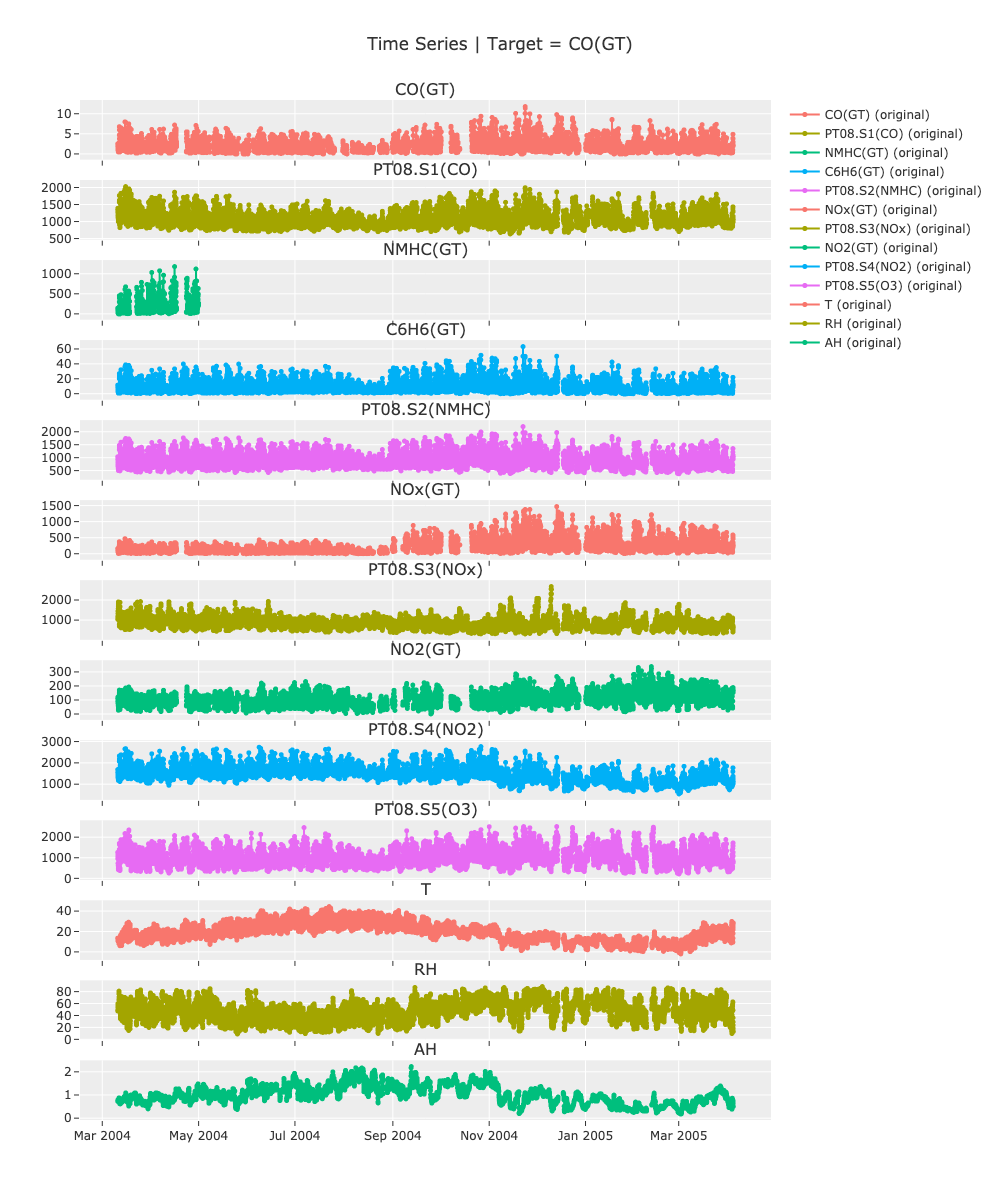

In [10]:
# 목표 변수와 그 외 변수를 함께 플롯합니다.
# 데이터가 상당히 크기 때문에, 인터랙티브한 플롯을 그리면 노트북의 속도가 느려질 수 있습니다.
# 따라서, 이 플롯에 대해서는 정적 렌더러로 되돌릴 것입니다.
eda.plot_model(fig_kwargs={"renderer": "png", "width": 1000, "height": 1200})

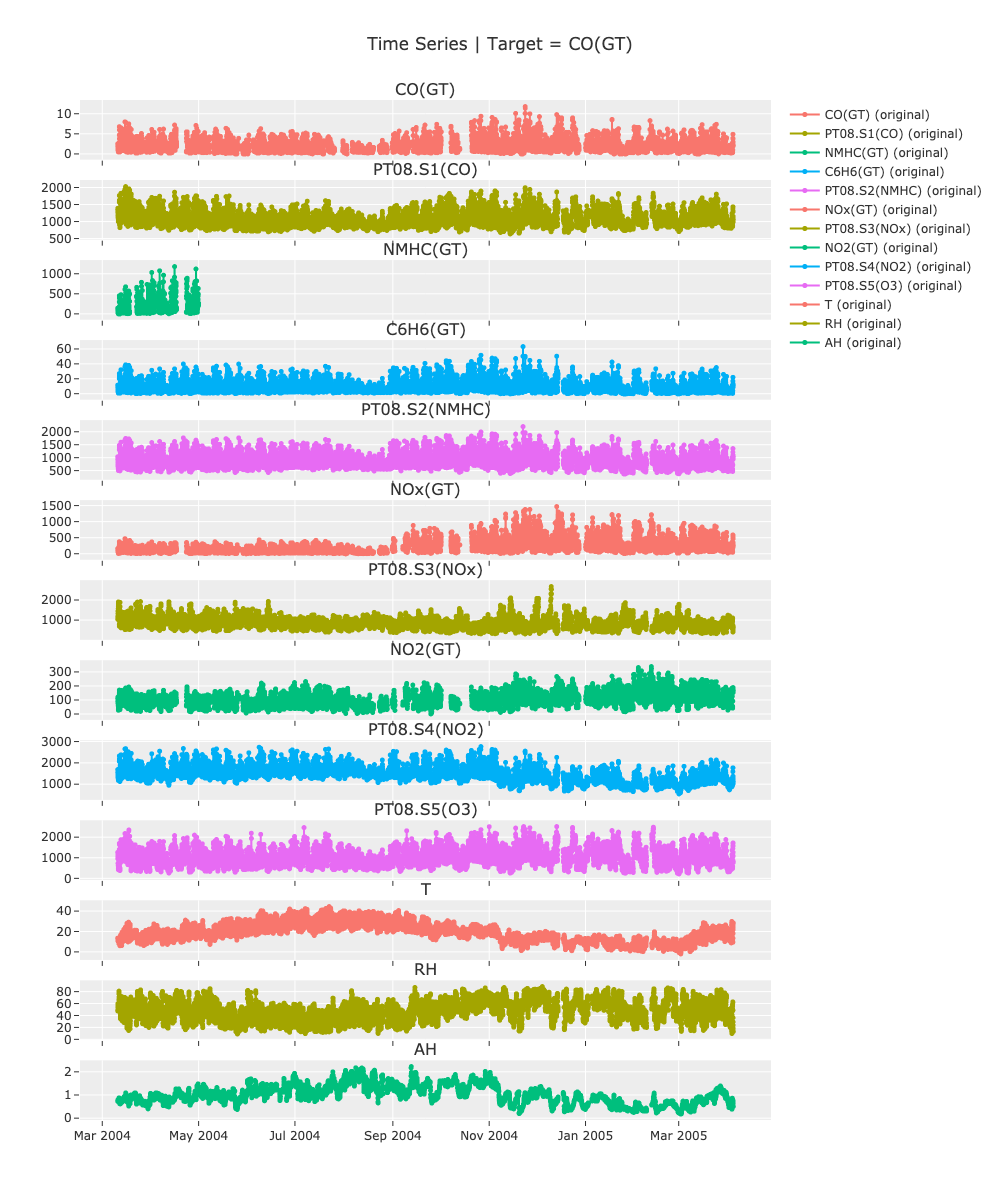

In [11]:
# 그러나, 당신이 `plotly-dash` 또는 `plotly-widget` 이라는 display_format을 사용할 때,
# plotly-resampler 툴킷은 시각화 백엔드로 사용될 것입니다.
# 이것은 데이터 집계를 허용함으로써 plotly-시각화를 빠르고 상호작용적으로 만듭니다.
# 확대/축소할 때, 관심 지역에 대해 데이터 포인트가 다시 렌더링됩니다.
# 주의: "plotly-widget"을 사용하려면 display_format 주석을 제거하세요.
eda.plot_model(
    plot="ts",
    fig_kwargs={
        'height': 1200,
# resampler_kwargs를 사용하여, plotly-resampler 객체의 생성자
# 구성할 수 있습니다.
        "resampler_kwargs": {
            "default_n_shown_samples": 1500,
# show_dash kwargs는 show_dash (render) 메서드의 kwargs를 보류합니다.
            "show_dash": {"mode": "inline", "port": 8055},
        },
    },
    # "plotly-dash" 형식으로 표시
)

확대 축소된 그래프에서 세부 사항을 보기 힘들 수도 있지만, pycaret는 인터랙티브 plotly 플롯을 사용하여 확대하는 기능을 제공합니다. 확대하면, 대략 19:00와 8:00에 피크가 있는 명확한 24시간 주기를 확인할 수 있습니다.

또한 `NMHC(GT)`는 모든 값이 누락된 것으로 보입니다. 우리는 차후에 개발할 다변량 모델에서 이 변수를 제거할 예정입니다.

다음으로, 설정에서는 데이터를 차분하는 것이 좋다고 권장하였습니다. 이것이 어떻게 보이는지, 그리고 필요한지 살펴보겠습니다. 차분된 데이터 외에도, 우리는 ACF, PACF 그리고 페리오도그램과 같은 일부 진단을 그려보겠습니다. 많은 독자들은 이미 ACF와 PACF에 대해 알고 있을 것이지만, 페리오도그램에 대해 좀 더 설명이 필요할 수 있습니다. 페리오도그램은 시계열에서 스펙트럼 밀도를 주파수 함수로 그리는 그래프입니다. 이 경우, 주파수는 0에서 0.5까지의 범위를 가집니다(주파수를 측정하는데 필요한 최소 점은 2개로, 이는 최대 주파수 0.5에 해당합니다). 여러 주파수에서의 크기는 시계열에 대한 중요한 특성을 파악하는 데 사용될 수 있습니다. 이에 대해서는 아래에서 살펴보겠습니다.


In [12]:
exclude = ["NMHC(GT)"]

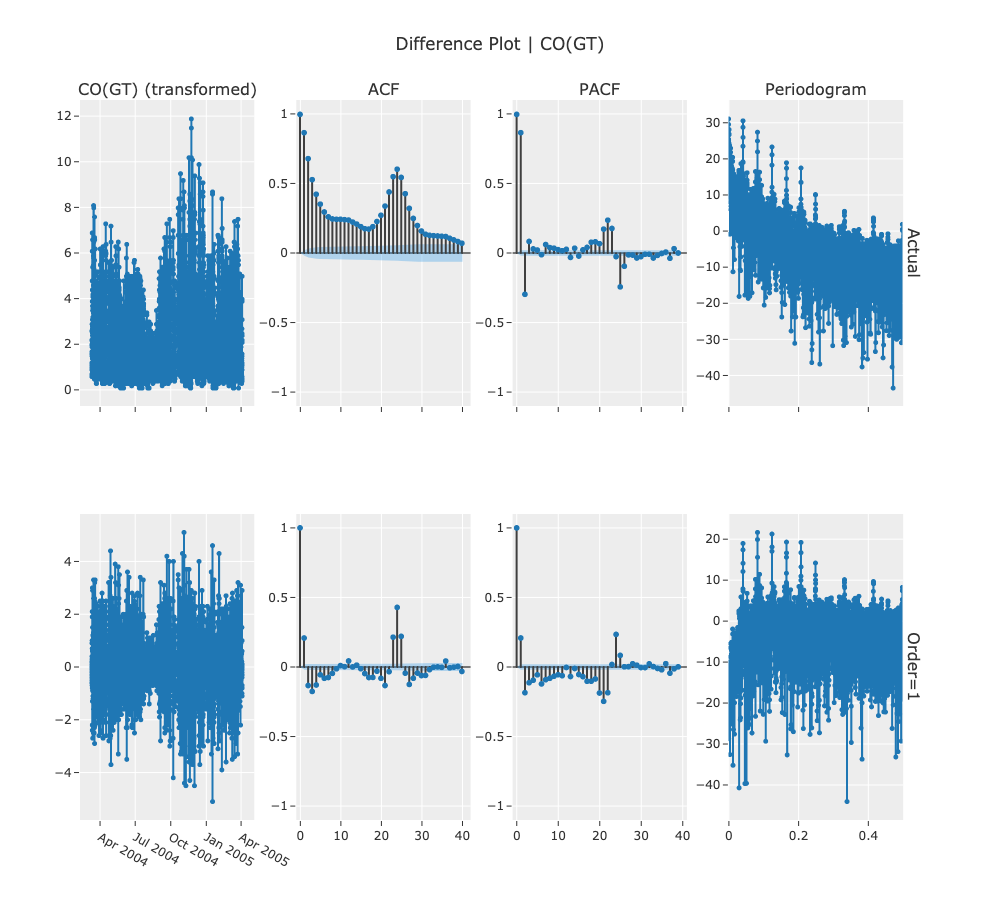

In [13]:
# 기본적으로 원본 데이터를 첫 번째 차분(order d = 1)과 함께 그래프로 그립니다.
# 주의: "plotly-widget"을 사용하려면 display_format의 주석 처리를 해제하세요.
eda.plot_model(
    plot="diff",
    fig_kwargs={
        "height": 900,
# plotly-widget을 사용할 때는 show_dash kwargs를 전달할 필요가 없습니다.
        "resampler_kwargs": {"default_n_shown_samples": 1500 }
    },
    data_kwargs={"acf": True, "pacf": True, "periodogram": True},
# "plotly-widget" 형식을 표시합니다.
)


위의 그래프들은 몇 가지 흥미로운 특성을 보여줍니다.

**원본**
1. 차분이 필요한가요?
  - 데이터셋은 상당히 높은 유의 수준을 보여주는 확장된 자기상관성(ACF - row 1, col 2)을 보여줍니다. 이는 차분이 필요하다는 것을 나타냅니다.
  - 같은 관측 결과는 PACF 플롯을 보면서도 파악할 수 있습니다. (row 1, col 3) 이는 lag1에서 매우 높은 상관관계를 보여줍니다. (즉, 이전 시점)
  - 이 특성은 주기도표 (row 1, col 4)에서도 확인할 수 있습니다. 이는 ~ f = 0에서 피크를 보여줍니다. (~ f = 0에서 피크가 나타나는 것은 시간 주기가 매우 크다는 것을 의미하며, 이는 "랜덤 워크" 유형의 행동을 차분으로 모델링할 수 있다는 것을 시사합니다.)
2. 계절성을 모델링해야 할까요?
  - ACF는 또한 lag 24에서 피크를 나타내어 24의 계절성을 보여줍니다. (이것은 설정 단계에서도 지목되었습니다.)
  - 이는 주기도표에서도 확인할 수 있습니다. (기본 f = 0.0417에서 피크를 보여주며, 그것의 고유 주파수는 0.0834,  0.1249, ...). f = 0.0417는 T = 1/0.0417 = 24, 즉 24시간의 계절 주기를 나타냅니다.

**차분 순서 = 1**
1. 차분 순서 = 1은 확장된 자기상관성의 많은 부분이 처리되었음을 보여줍니다. (row 2, col 2의 크기가 이전보다 훨씬 작습니다.) 이는 주기도표 (row 2, col 4)에서도 확인할 수 있습니다. 여기서 ~ f = 0에서의 크기가 이전보다 훨씬 작습니다.
2. ACF는 여전히 lag = 24에서 피크를 보여주며, 주기도표도 이를 나타냅니다. 이는 우리가 이를 적절히 모델링하기 위해 여전히 처리해야 함을 나타냅니다. 다음으로 계절성을 포함한 차분을 플로팅함으로써 이를 처리해봅시다. 이번에는 분석에 더 세밀한 제어를 원하기 때문에 lag들을 명확히 지정하겠습니다.

참고: lag = 1은 차분 순서 = 1, 즉 첫 번째 차분을 의미하며, lag = [1, 24]는 첫 번째 차분이 취해진 다음 계절 차분 24가 취해진다는 것을 의미합니다.

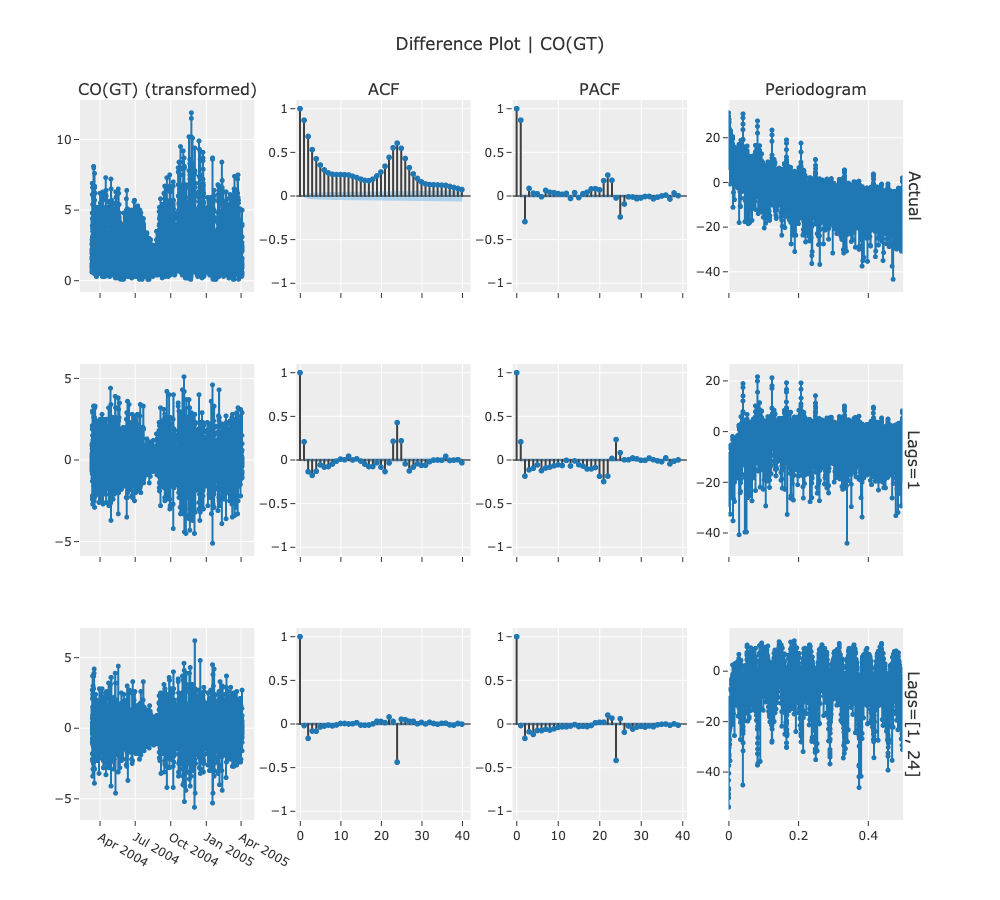

In [14]:
eda.plot_model(
    plot="diff",
    fig_kwargs={
        "height": 900,
        "resampler_kwargs": {
            "default_n_shown_samples": 1500,
            "show_dash": {"mode": "inline", "port": 8056},
        },
    },
    data_kwargs={
        "lags_list": [1, [1, 24]],
        "acf": True,
        "pacf": True,
        "periodogram": True,
    },
    # 'plotly-dash' 형식으로 표시
)


우리는 마지막 플롯의 반복이 되는 첫 번째와 두 번째 행보다는 3번째 행에 주목할 것입니다. 3번째 행은 24의 계절 차분이 뒤따르는 1차 차분을 표현합니다. ACF(행 3, 열 2)에서 볼 수 있듯이, 모든 확장 자기상관이 처리되었습니다. 우리는 여전히 lag = 24에서 피크를 보지만(이제는 음수), 페리오도그램을 주의 깊게 검토하면, 누출이 매우 낮은 스펙트럼 밀도를 가지고 있다는 것을 알 수 있습니다. 따라서, 첫 번째 차분과 24의 계절 차분을 취하면 이 시계열을 상당히 합리적으로 모델링할 수 있다는 결론을 내릴 수 있습니다. 그러나,

참고: 독자는 이것을 더욱 조사하여 AR 및 MA 구성 요소를 알아낼 수 있습니다. 예를 들어, PACF 플롯(행 3, 열 3)은 lag = 2에서 그리고 그 이후에서 음의 스파이크(중요)를 보여줌으로써 적어도 2차 AR 구성 요소를 나타냅니다. 단순성을 위해 이번 연습에서는 그것을 사용하지 않겠지만, 더 완전한 평가를 위해 반드시 탐색해야 합니다.

다음으로, 외생 변수가 타겟에 미치는 영향과 그 사이의 상관 관계를 조사해 보겠습니다. 이는 Cross Correlation Plots을 이용하여 달성할 수 있습니다.

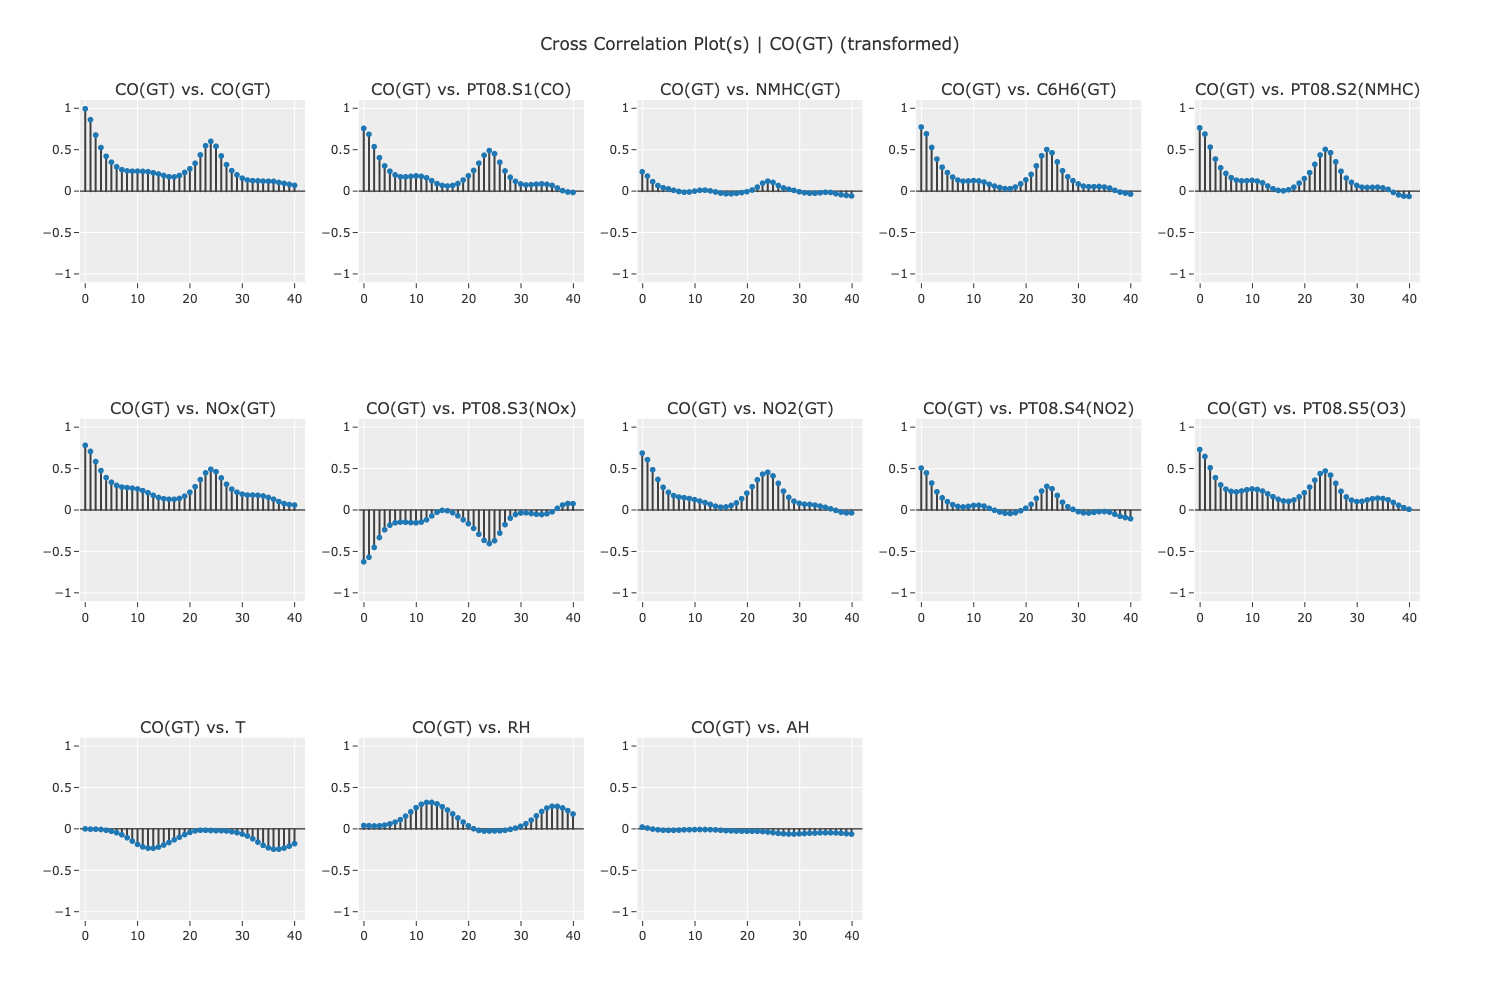

In [15]:
eda.plot_model(plot="ccf", fig_kwargs={"height": 1000, "width": 1500})

첫 번째 플롯(행 1, 열 1)은 타겟의 자기상관성을 보여주며(ACF와 같음), 나머지 플롯들은 타겟과 외생 변수의 지연된 값들 사이의 상관성을 보여줍니다. 예를 들어, 행 1, 열 2는 CO 농도가 lag 0과 lag 24에서 `PT08.S1(CO)`와 매우 상관관계가 있음을 보여줍니다. `NOx(GT)`, `C6H6(GT)`, `PT08.S2(NMHC)` 등 다른 변수들에서도 비슷한 패턴을 볼 수 있습니다. 이 변수들은 CO 농도를 모델링할 때 유용할 수 있습니다.

또 하나의 관찰 결과로, 절대 습도 `AH`는 CO 농도와 매우 강한 상관관계를 보이지 않는 것으로 보입니다. 이 변수는 모델링에 중요하지 않을 수 있습니다.

In [16]:
exclude.append("AH")
exclude

['NMHC(GT)', 'AH']